# Train a scVI model using Lamin

This notebook demonstrates a scalable approach to training an [scVI](https://docs.scvi-tools.org/en/latest/user_guide/models/scvi.html) model on Census data using [Lamin](https://lamin.ai/) dataloader.
LaminDB is a database system based on its MappedCollection designed to support efficient storage, management, and querying of scientific data, particularly in machine learning, bioinformatics, and data science applications. It allows for the easy organization, sharing, and querying of complex datasets, such as those involved in research, experiments, or models.
See [here](https://docs.scvi-tools.org/en/stable/user_guide/use_case/custom_dataloaders.html) for more information

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

In [2]:
import os
import time

import scanpy as sc
import scvi
from scvi.dataloaders import MappedCollectionDataModule

→ connected lamindb: anonymous/lamindb_collection


In [4]:
os.system("lamin init --storage ./lamindb_collection")  # one time for github runner (comment)
import lamindb as ln
# ln.setup.init()

In [6]:
pbmc_dataset = scvi.data.pbmc_dataset(
    save_path=".",
    remove_extracted_data=True,
)

INFO     File ./gene_info_pbmc.csv already downloaded                                                              
INFO     File ./pbmc_metadata.pickle already downloaded                                                            
INFO     File ./pbmc8k/filtered_gene_bc_matrices.tar.gz already downloaded                                         
INFO     Extracting tar file                                                                                       
INFO     Removing extracted data at ./pbmc8k/filtered_gene_bc_matrices                                             
INFO     File ./pbmc4k/filtered_gene_bc_matrices.tar.gz already downloaded                                         
INFO     Extracting tar file                                                                                       
INFO     Removing extracted data at ./pbmc4k/filtered_gene_bc_matrices                                             


/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scvi/data/_built_in_data/_pbmc.py:75: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = pbmc8k.concatenate(pbmc4k)


In [7]:
pbmc_seurat_v4_cite_seq = scvi.data.pbmc_seurat_v4_cite_seq(save_path=".")

INFO     File ./pbmc_seurat_v4.h5ad already downloaded                                                             


In [8]:
pbmc_seurat_v4_cite_seq.obs["batch"] = pbmc_seurat_v4_cite_seq.obs.Phase

In [9]:
pbmc_seurat_v4_cite_seq.obs["batch"] = pbmc_seurat_v4_cite_seq.obs["batch"].astype("str")
pbmc_dataset.obs["batch"] = pbmc_dataset.obs["batch"].astype("str")

In [10]:
import numpy as np

gene_intersection = np.intersect1d(
    pbmc_dataset.var.gene_symbols.values, pbmc_seurat_v4_cite_seq.var.index.values
)
pbmc_dataset_filtered = pbmc_dataset[:, pbmc_dataset.var["gene_symbols"].isin(gene_intersection)]
pbmc_seurat_v4_cite_seq_filtered = pbmc_seurat_v4_cite_seq[
    :, pbmc_seurat_v4_cite_seq.var_names.isin(gene_intersection)
]

In [11]:
pbmc_dataset_filtered.var_names = pbmc_dataset_filtered.var["gene_symbols"].values

In [12]:
# prepare test data
# adata1 = synthetic_iid()
# adata2 = synthetic_iid()

artifact1 = ln.Artifact.from_anndata(pbmc_dataset_filtered, key="part_one.h5ad").save()
artifact2 = ln.Artifact.from_anndata(pbmc_seurat_v4_cite_seq_filtered, key="part_two.h5ad").save()

collection = ln.Collection([artifact1, artifact2], key="gather")
collection.save()

! no run & transform got linked, call `ln.track()` & re-run
→ returning existing artifact with same hash: Artifact(uid='M18k5o0Xe3qDFjOv0003', is_latest=True, key='part_one.h5ad', suffix='.h5ad', kind='dataset', otype='AnnData', size=49786072, hash='J1SVlkMwG8qhvBVl785THw', n_observations=11990, space_id=1, storage_id=1, created_by_id=1, created_at=2025-04-23 08:50:20 UTC); to track this artifact as an input, use: ln.Artifact.get()
! no run & transform got linked, call `ln.track()` & re-run


/home/access/.conda/envs/scvi/lib/python3.12/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


→ returning existing artifact with same hash: Artifact(uid='1DZ49fivMXjvwSiO0002', is_latest=True, key='part_two.h5ad', suffix='.h5ad', kind='dataset', otype='AnnData', size=998735217, hash='-1wt2yjFXKCQVZmvWLazSl', n_observations=152094, space_id=1, storage_id=1, created_by_id=1, created_at=2025-04-23 08:46:24 UTC); to track this artifact as an input, use: ln.Artifact.get()
! no run & transform got linked, call `ln.track()` & re-run
! returning existing collection with same hash: Collection(uid='6IASvDXmFbji3Uzu0004', is_latest=True, key='gather', hash='oC2QvedQV1c5ylpjGfSrYQ', space_id=1, created_by_id=1, created_at=2025-04-23 08:50:22 UTC); if you intended to query to track this collection as an input, use: ln.Collection.get()
! run input wasn't tracked, call `ln.track()` and re-run
! run input wasn't tracked, call `ln.track()` and re-run


Collection(uid='6IASvDXmFbji3Uzu0004', is_latest=True, key='gather', hash='oC2QvedQV1c5ylpjGfSrYQ', space_id=1, created_by_id=1, created_at=2025-04-23 08:50:22 UTC)

In [13]:
pbmc_dataset_filtered

AnnData object with n_obs × n_vars = 11990 × 3315
    obs: 'n_counts', 'batch', 'labels', 'str_labels'
    var: 'gene_symbols', 'n_counts-0', 'n_counts-1', 'n_counts'
    uns: 'cell_types'
    obsm: 'design', 'raw_qc', 'normalized_qc', 'qc_pc'

In [14]:
pbmc_seurat_v4_cite_seq_filtered

AnnData object with n_obs × n_vars = 152094 × 3315
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'X_index', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'Protein log library size', 'Number proteins detected', 'RNA log library size', 'batch'
    var: 'mt'
    obsm: 'protein_counts'

In [15]:
# We load the collection to see it consists of many h5ad files
artifacts = collection.artifacts.all()
artifacts.df()

! no run & transform got linked, call `ln.track()` & re-run
! run input wasn't tracked, call `ln.track()` and re-run


,uid,key,description,suffix,kind,otype,size,hash,n_files,n_observations,_hash_type,_key_is_virtual,_overwrite_versions,space_id,storage_id,schema_id,version,is_latest,run_id,created_at,created_by_id,_aux,_branch_code
id,,,,,,,,,,,,,,,,,,,,,,,
5,1DZ49fivMXjvwSiO0002,part_two.h5ad,None,.h5ad,dataset,AnnData,998735217,-1wt2yjFXKCQVZmvWLazSl,None,152094,sha1-fl,True,False,1,1,None,None,True,None,2025-04-23 08:46:24.741000+00:00,1,None,1
7,M18k5o0Xe3qDFjOv0003,part_one.h5ad,None,.h5ad,dataset,AnnData,49786072,J1SVlkMwG8qhvBVl785THw,None,11990,md5,True,False,1,1,None,None,True,None,2025-04-23 08:50:20.537000+00:00,1,None,1


In [16]:
# we can now define the batch and data loader
batch_keys = "batch"
datamodule = MappedCollectionDataModule(
    collection,
    batch_key=batch_keys,
    batch_size=1024,
    join="inner",
)

! run input wasn't tracked, call `ln.track()` and re-run
! run input wasn't tracked, call `ln.track()` and re-run
! run input wasn't tracked, call `ln.track()` and re-run


In [17]:
print(datamodule.n_obs, datamodule.n_vars, datamodule.n_batch)

164084 3315 5


In [18]:
print(datamodule.registry)

{'scvi_version': '1.3.1', 'model_name': 'SCVI', 'setup_args': {'layer': None, 'batch_key': 'batch', 'labels_key': None, 'size_factor_key': None, 'categorical_covariate_keys': None, 'continuous_covariate_keys': None}, 'field_registries': {'X': {'data_registry': {'attr_name': 'X', 'attr_key': None}, 'state_registry': {'n_obs': 164084, 'n_vars': 3315, 'column_names': Index(['NOC2L', 'ISG15', 'PLCH2', 'PANK4', 'TNFRSF14', 'LRRC47', 'C1orf174',
       'NOL9', 'ZBTB48', 'KLHL21',
       ...
       'WDR4', 'U2AF1', 'CSTB', 'AGPAT3', 'AIRE', 'PTTG1IP', 'ITGB2', 'PCNT',
       'DIP2A', 'S100B'],
      dtype='object', length=3315)}, 'summary_stats': {'n_vars': 3315, 'n_cells': 164084}}, 'batch': {'data_registry': {'attr_name': 'obs', 'attr_key': '_scvi_batch'}, 'state_registry': {'categorical_mapping': {'0': 0, '1': 1, 'G1': 2, 'G2M': 3, 'S': 4}, 'original_key': 'batch'}, 'summary_stats': {'n_batch': 5}}, 'labels': {'data_registry': {'attr_name': 'obs', 'attr_key': '_scvi_labels'}, 'state_regist

In [19]:
# Init the model
model = scvi.model.SCVI(registry=datamodule.registry)

In [20]:
# Training the model
start = time.time()
model.train(
    max_epochs=100,
    batch_size=1024,
    datamodule=datamodule,
    # datamodule=datamodule.train_dataloader()
)
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX 6000 Ada Generation') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/100 [00:00<?, ?it/s]

/home/access/.conda/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1024. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 244. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
`Trainer.fit` stopped: `max_epochs=100` reached.


Elapsed time: 471.88 seconds


In [21]:
# Save the model
model.save("lamin_model", save_anndata=False, overwrite=True, datamodule=datamodule)

In [22]:
model.history.keys()

dict_keys(['kl_weight', 'train_loss_step', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train'])

In [23]:
# The way to extract the internal model analysis is by the inference_dataloader
# Datamodule will always require to pass it into all downstream functions.
inference_dataloader = datamodule.inference_dataloader()
latent = model.get_latent_representation(dataloader=inference_dataloader)

In [24]:
# We extract the adata of the model, to be able to plot it
adata = collection.load(join="inner")

! run input wasn't tracked, call `ln.track()` and re-run


In [25]:
adata.obsm["scvi"] = latent

In [55]:
adata.obs["cell_type"] = (
    pbmc_dataset_filtered.obs.str_labels.values.tolist()
    + pbmc_seurat_v4_cite_seq_filtered.obs["celltype.l1"].values.tolist()
)

In [69]:
adata

AnnData object with n_obs × n_vars = 164084 × 3315
    obs: 'batch', 'artifact_uid', '_scvi_batch', '_scvi_labels', 'cell_type'
    uns: 'scvi', 'umap', 'batch_colors', 'log1p', '_scvi_uuid', '_scvi_manager_uuid', 'scvi_non_dataloder', 'cell_type_colors'
    obsm: 'scvi', 'X_umap', 'scvi_non_dataloder'
    layers: 'counts'
    obsp: 'scvi_distances', 'scvi_connectivities', 'scvi_non_dataloder_distances', 'scvi_non_dataloder_connectivities'

In [66]:
# We can now generate the neighbors and the UMAP.
sc.pp.neighbors(adata, use_rep="scvi", key_added="scvi")
sc.tl.umap(adata, neighbors_key="scvi")

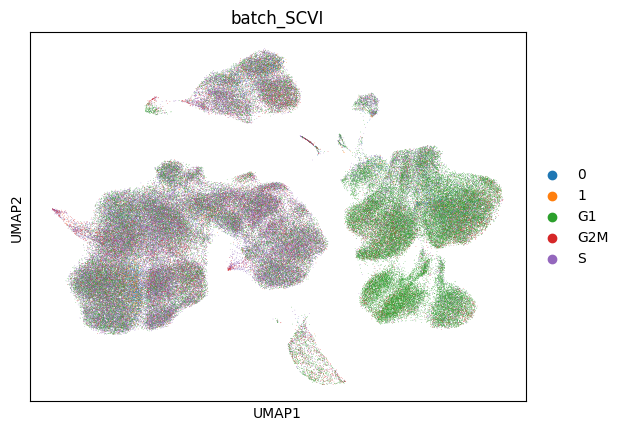

In [67]:
sc.pl.umap(adata, color=batch_keys, title="batch_SCVI")

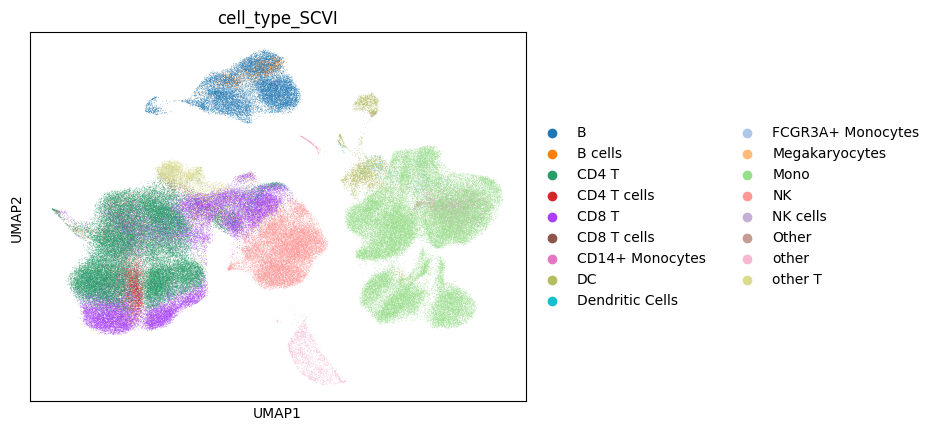

In [68]:
sc.pl.umap(adata, color="cell_type", title="cell_type_SCVI")

run regulary using adata and compare

In [33]:
adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata  # freeze the state in `.raw`

In [34]:
# sc.pp.highly_variable_genes(
#    adata,
#    n_top_genes=top_n_hvg,
#    subset=True,
#    layer="counts",
#    flavor="seurat_v3",
#    batch_key="dataset_id",
# )

In [35]:
adata.obs

,batch,artifact_uid
AAACCTGAGCTAGTGG-1,0,M18k5o0Xe3qDFjOv0003
AAACCTGCACATTAGC-1,0,M18k5o0Xe3qDFjOv0003
AAACCTGCACTGTTAG-1,0,M18k5o0Xe3qDFjOv0003
AAACCTGCATAGTAAG-1,0,M18k5o0Xe3qDFjOv0003
AAACCTGCATGAACCT-1,0,M18k5o0Xe3qDFjOv0003
...,...,...
E2L8_TTTGTTGGTCGTGATT,S,1DZ49fivMXjvwSiO0002
E2L8_TTTGTTGGTGTGCCTG,G1,1DZ49fivMXjvwSiO0002
E2L8_TTTGTTGGTTAGTTCG,S,1DZ49fivMXjvwSiO0002
E2L8_TTTGTTGGTTGGCTAT,G1,1DZ49fivMXjvwSiO0002


In [36]:
scvi.model.SCVI.setup_anndata(adata, batch_key="batch", layer="counts")

In [37]:
# model_census3 = scvi.model.SCVI.load("census_model", adata=adata)
model_census3 = scvi.model.SCVI(adata)

In [38]:
start2 = time.time()
model_census3.train(
    max_epochs=100,
)
end2 = time.time()
print(f"Elapsed time: {end2 - start2:.2f} seconds")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Elapsed time: 484.23 seconds


In [62]:
adata.obsm["scvi_non_dataloder"] = model_census3.get_latent_representation()

In [63]:
sc.pp.neighbors(adata, use_rep="scvi_non_dataloder", key_added="scvi_non_dataloder")
sc.tl.umap(adata, neighbors_key="scvi_non_dataloder")

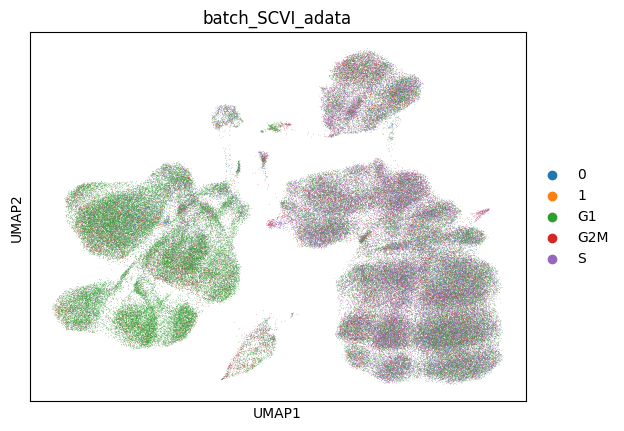

In [64]:
sc.pl.umap(adata, color="batch", title="batch_SCVI_adata")

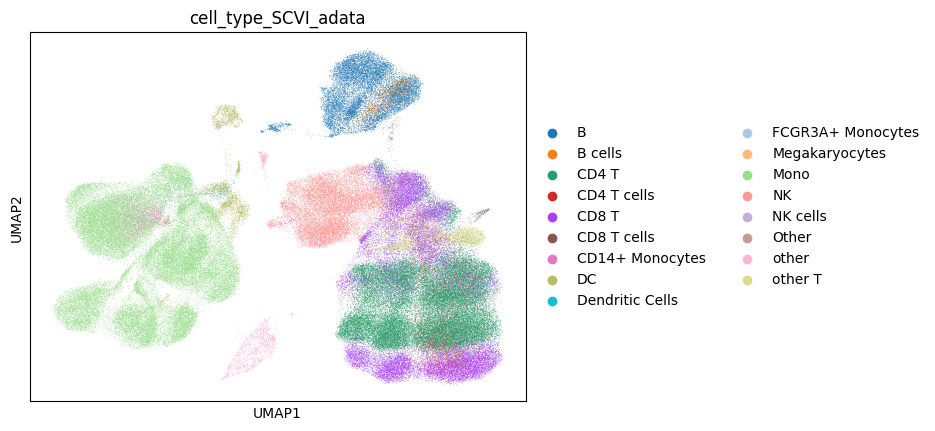

In [65]:
sc.pl.umap(adata, color="cell_type", title="cell_type_SCVI_adata")

Compute integration metrics

In [70]:
from scib_metrics.benchmark import Benchmarker

bm = Benchmarker(
    adata,
    batch_key="batch",
    label_key="cell_type",
    embedding_obsm_keys=["X_pca", "scvi", "scvi_non_dataloder"],
    n_jobs=-1,
)
bm.benchmark()

/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
rics:  60%|████████████████████████████████████████████████████▏                                  | 6/10 [00:20<00:12,  3.11s/it, Batch correction: kbet_per_label]

INFO     17 clusters consist of a single batch or are too small. Skip.                                             


/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scib_metrics/metrics/_kbet.py:212: RuntimeWarning: Mean of empty slice
  final_score = np.nanmean(kbet_scores["kBET"])

rics:  70%|████████████████████████████████████████████████████████████▉                          | 7/10 [00:22<00:07,  2.52s/it, Batch correction: kbet_per_label]
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)

Embeddings:  33%|███████████████████████████████████████▋                                                                               | 1/3 [00:22<00:45, 22.83s/it]
                                                                                                                                                                   
rics:  60%|███████████████████████████████████████████

INFO     17 clusters consist of a single batch or are too small. Skip.                                             


/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scib_metrics/metrics/_kbet.py:212: RuntimeWarning: Mean of empty slice
  final_score = np.nanmean(kbet_scores["kBET"])

rics:  70%|████████████████████████████████████████████████████████████▉                          | 7/10 [00:07<00:02,  1.09it/s, Batch correction: kbet_per_label]
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)

Embeddings:  67%|███████████████████████████████████████████████████████████████████████████████▎                                       | 2/3 [00:30<00:14, 14.14s/it]
                                                                                                                                                                   
rics:  60%|███████████████████████████████████████████

INFO     17 clusters consist of a single batch or are too small. Skip.                                             


/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scib_metrics/metrics/_kbet.py:212: RuntimeWarning: Mean of empty slice
  final_score = np.nanmean(kbet_scores["kBET"])

rics:  70%|████████████████████████████████████████████████████████████▉                          | 7/10 [00:06<00:02,  1.32it/s, Batch correction: kbet_per_label]
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)

Embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:37<00:00, 12.52s/it]

                                                                                                                                                                   

/home/access/.conda/envs/scvi/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


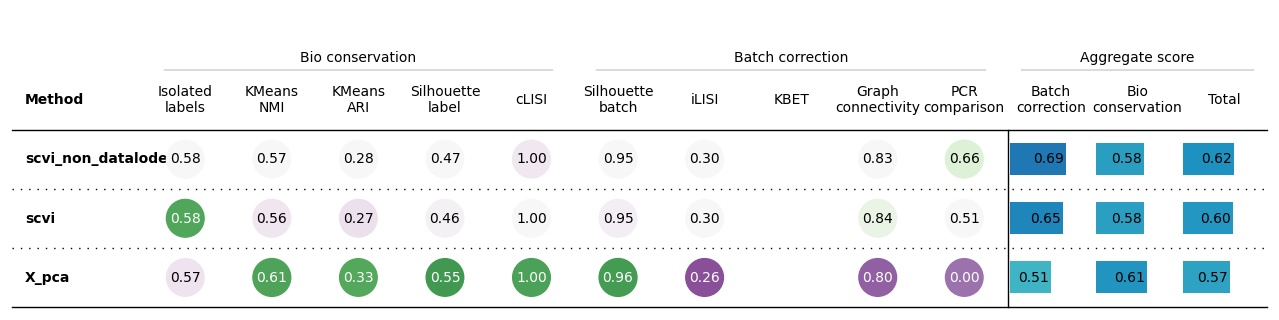

In [71]:
bm.plot_results_table(min_max_scale=False)